<a href="https://colab.research.google.com/github/RudraPramanik/applied-reinforcement-learning/blob/master/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
### Reinforcement Learning

Proximal Policy Optimization (PPO) is the "industry standard" RL algorithm. Developed by OpenAI, it is the backbone of modern AI systems like ChatGPT.

**In this notebook, we will:**
1.  **Deconstruct the Math:** Understand the Clipped Objective function using LaTeX.
2.  **Generate Synthetic Data:** Build a custom 1D "Target-Seeker" environment.
3.  **Implement Actor-Critic:** Create a dual-headed neural network.
4.  **Analyze Stability:** Observe how clipping prevents policy collapse.

In [1]:
# Install libraries
!pip install gymnasium matplotlib torch numpy

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. The Mathematical Innovation: PPO-Clip

The primary challenge in Reinforcement Learning is the **Step Size**. If you update your policy too much based on a single batch of data, the agent might learn a "wrong" behavior that it can never recover from.

PPO introduces the **Clipped Surrogate Objective**. Let the probability ratio between the new policy $\pi_{\theta}$ and the old policy $\pi_{\theta_{old}}$ be:

$$r_t(\theta) = \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

The PPO objective function $L^{CLIP}$ is defined as:

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t) \right]$$

### **Why the 'Min' and 'Clip'?**
* **$\hat{A}_t$ (Advantage):** Tells us if the action was better than average.
* **The Clip:** If the ratio $r_t(\theta)$ moves too far away from $1.0$ (more than $\epsilon$), we "clip" the gradient. This ensures the update stays within a **Trust Region**.

In [3]:
class SyntheticTargetEnv(gym.Env):
    """A simple 1D world where the agent wants to reach a target."""
    def __init__(self):
        super(SyntheticTargetEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2) # 0: Left, 1: Right
        self.state = 0.0
        self.target = 10.0

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.state = 0.0
        return np.array([self.state], dtype=np.float32), {}

    def step(self, action):
        # Move agent
        step_size = 0.5
        if action == 1: self.state += step_size
        else: self.state -= step_size

        # Keep in bounds
        self.state = np.clip(self.state, 0, 10)

        # Reward: Closer to 10 is better
        reward = -abs(self.state - self.target) / 10.0
        terminated = bool(self.state >= 9.5)

        if terminated: reward += 10.0 # Bonus for reaching goal

        return np.array([self.state], dtype=np.float32), reward, terminated, False, {}

# Test the environment
env = SyntheticTargetEnv()
print("Env initialized. Action Space:", env.action_space)

Env initialized. Action Space: Discrete(2)


## Synthetic Data Generation: The 1D World

To keep this lesson lightweight and "Colab-ready," we use a **Synthetic Environment**. Instead of loading a 500MB game engine, we define a mathematical world:

* **State Space:** A continuous value $s \in [0, 10]$.
* **Action Space:** Discrete actions $\{0, 1\}$ (Left or Right).
* **Reward Function:** * Step penalty: $-|s - 10|/10$
    * Goal bonus: $+10$ when $s \geq 9.5$.

This provides a clear signal for the agent: **"The further right you go, the higher the reward."**

##  The Actor-Critic Architecture

We use a "Shared Backbone" architecture. The network processes the state and then splits into two specialized heads:

1.  **The Actor (Policy):** Outputs a probability distribution (Softmax) over possible actions.
2.  **The Critic (Value):** Outputs a single scalar value representing the expected future reward from the current state.



| Component | Output Type | Purpose |
| :--- | :--- | :--- |
| **Backbone** | Feature Vector | Internal representation of the state |
| **Actor Head** | Probability | Action selection ($\pi$) |
| **Critic Head** | Scalar Value | Estimating $V(s)$ |

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared_net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )

        # Actor head: Outputs probabilities for actions
        self.actor = nn.Sequential(
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic head: Outputs a single value (V-value)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        features = self.shared_net(x)
        return self.actor(features), self.critic(features)

##  Training Loop: The PPO Cycle

PPO is an **On-Policy** algorithm, meaning it follows this specific cycle:

1.  **Collection:** Play $N$ steps using the **Old Policy** and store transitions $(s, a, r)$ in a buffer.
2.  **Advantage Calculation:** Use the Critic to estimate how much better each action was than expected.
3.  **Optimization:** Update the **New Policy** using the Clipped Objective for $K$ epochs.
4.  **Synchronization:** Copy the New Policy weights to the Old Policy and repeat.

In [7]:
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.gamma = 0.99
        self.eps_clip = 0.2
        self.k_epochs = 4 # How many times to learn from one batch of data

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.002)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state, memory):
        state = torch.FloatTensor(state).to(device)
        probs, state_value = self.policy_old(state)

        dist = Categorical(probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def update(self, memory):
        # 1. Calculate Rewards-to-go (Monte Carlo estimates)
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal: discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalize rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Convert list to tensors
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # 2. PPO Optimization loop
        for _ in range(self.k_epochs):
            # Evaluating old actions and values
            logprobs, state_values = self.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # Final Loss = Policy Loss + Value Loss
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards)

            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

    def evaluate(self, state, action):
        probs, state_value = self.policy(state)
        dist = Categorical(probs)
        action_logprobs = dist.log_prob(action)
        return action_logprobs, torch.squeeze(state_value)

class Memory:
    def __init__(self):
        self.actions, self.states, self.logprobs, self.rewards, self.is_terminals = [], [], [], [], []
    def clear(self):
        del self.actions[:], self.states[:], self.logprobs[:], self.rewards[:], self.is_terminals[:]

##  Hyperparameters for Stability

| Hyperparameter | Value | Description |
| :--- | :--- | :--- |
| `lr` | $0.001$ | Learning rate for Adam optimizer |
| `gamma` ($\gamma$) | $0.99$ | Discount factor for future rewards |
| `eps_clip` ($\epsilon$) | $0.2$ | The range for the clipping function |
| `K_epochs` | $5$ | How many times to reuse a single rollout batch |

In [8]:
# Initialize Agent and Environment
env = SyntheticTargetEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPOAgent(state_dim, action_dim)
memory = Memory()

max_episodes = 200
update_timestep = 500  # Update policy every X steps
timestep = 0
history = []

for i_episode in range(1, max_episodes + 1):
    state, _ = env.reset()
    episode_reward = 0

    for t in range(100): # Max steps per episode
        timestep += 1

        # Agent selects action
        action = agent.select_action(state, memory)
        state, reward, done, _, _ = env.step(action)

        # Saving reward and is_terminals
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        episode_reward += reward

        # Update PPO Agent
        if timestep % update_timestep == 0:
            agent.update(memory)
            memory.clear()
            timestep = 0

        if done: break

    history.append(episode_reward)

    if i_episode % 10 == 0:
        print(f"Episode {i_episode} \t Last Reward: {episode_reward:.2f}")

print("Training Complete!")

Episode 10 	 Last Reward: -90.50
Episode 20 	 Last Reward: -89.85
Episode 30 	 Last Reward: -27.65
Episode 40 	 Last Reward: -16.20
Episode 50 	 Last Reward: -11.80
Episode 60 	 Last Reward: -3.80
Episode 70 	 Last Reward: -11.95
Episode 80 	 Last Reward: -3.60
Episode 90 	 Last Reward: -0.50
Episode 100 	 Last Reward: 0.50
Episode 110 	 Last Reward: -0.15
Episode 120 	 Last Reward: -2.45
Episode 130 	 Last Reward: -0.50
Episode 140 	 Last Reward: -3.35
Episode 150 	 Last Reward: -1.75
Episode 160 	 Last Reward: 0.50
Episode 170 	 Last Reward: 0.50
Episode 180 	 Last Reward: -1.80
Episode 190 	 Last Reward: -0.50
Episode 200 	 Last Reward: -2.45
Training Complete!


##  Results & Analysis

When you run the code below, watch the reward curve.
* **Stochastic Phase:** Early on, the reward fluctuates wildly as the agent explores.
* **Convergence:** Once the Critic learns a stable baseline, the Actor's clipping ensures the reward grows steadily without "crashing."

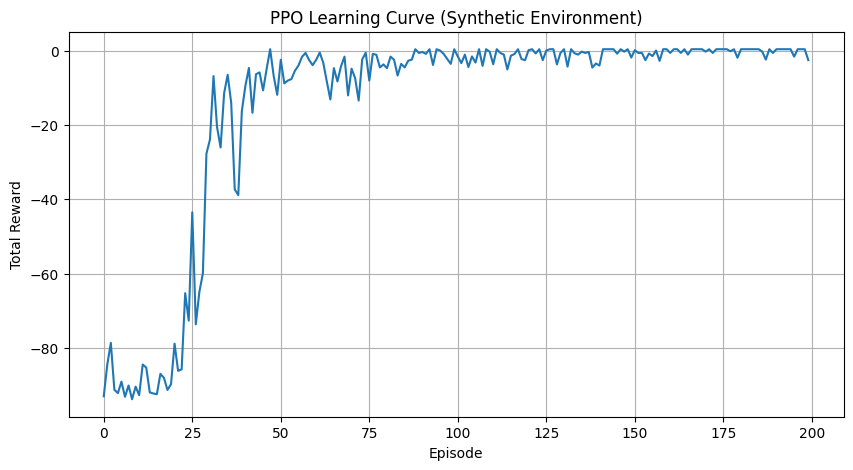

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history)
plt.title("PPO Learning Curve (Synthetic Environment)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()